In [197]:
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
from tqdm import tqdm

In [198]:
SEED = 42
EPOCHS = 100
BATCH = 32
IMG_HEIGHT = 192
IMG_WIDTH = 256

# CATARACT DATASET
IMG_ROOT = "dataset/"
IMG_DIR = [
    IMG_ROOT + "normal",
    IMG_ROOT + "cataract",
    IMG_ROOT + "glaucoma",
    IMG_ROOT + "retina_disease",
]

#ocular-disease-recognition dataset
OCU_IMG_ROOT = 'ocular/ODIR-5K/ODIR-5K/Training Images/'
ocu_df = pd.read_excel('ocular/ODIR-5K/ODIR-5K/data.xlsx', engine='openpyxl')

In [199]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_random_seed(seed)
    
seed_everything(SEED)

In [200]:
cat_df = pd.DataFrame(0, 
                  columns=['paths', 
                           'cataract'],
                  index=range(601))

filepaths = glob.glob(IMG_ROOT + '*/*')


for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]
    
    if filepath[0] == IMG_DIR[0]:    # normal
        cat_df.iloc[i, 1] = 0
    elif filepath[0] == IMG_DIR[1]:  # cataract
        cat_df.iloc[i, 1] = 1
    elif filepath[0] == IMG_DIR[2]:  # glaucoma
        cat_df.iloc[i, 1] = 2
    elif filepath[0] == IMG_DIR[3]:  # retine_disease
        cat_df.iloc[i, 1] = 3
        
# only sample normal and cataract        
cat_df = cat_df.query('0 <= cataract < 2')
cat_df

,paths,cataract
101,dataset/cataract/cataract_062.png,1
102,dataset/cataract/cataract_099.png,1
103,dataset/cataract/cataract_023.png,1
104,dataset/cataract/cataract_083.png,1
105,dataset/cataract/cataract_052.png,1
...,...,...
596,dataset/normal/NL_032.png,0
597,dataset/normal/NL_076.png,0
598,dataset/normal/NL_070.png,0
599,dataset/normal/NL_115.png,0


In [201]:
print('Number of normal and cataract images')
print(cat_df['cataract'].value_counts())

Number of normal and cataract images
0    300
1    100
Name: cataract, dtype: int64


In [202]:
#PROCESS OCULAR DISEASE DATASET
ocu_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [203]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0
    
ocu_df['left_eye_cataract'] = ocu_df['Left-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))
ocu_df['right_eye_cataract'] = ocu_df['Right-Diagnostic Keywords']\
                                 .apply(lambda x: has_cataract_mentioned(x))

In [204]:
le_df = ocu_df.loc[:, ['Left-Fundus', 'left_eye_cataract']]\
        .rename(columns={'left_eye_cataract':'cataract'})
le_df['paths'] = OCU_IMG_ROOT + le_df['Left-Fundus']
le_df = le_df.drop('Left-Fundus', axis=1)


re_df = ocu_df.loc[:, ['Right-Fundus', 'right_eye_cataract']]\
        .rename(columns={'right_eye_cataract':'cataract'})
re_df['paths'] = OCU_IMG_ROOT + re_df['Right-Fundus']
re_df = re_df.drop('Right-Fundus', axis=1)

In [205]:
print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
0    3341
1     159
Name: cataract, dtype: int64

Number of right eye images
0    3346
1     154
Name: cataract, dtype: int64


In [206]:
def downsample(df):
    df = pd.concat([
        df.query('cataract==1'),
        df.query('cataract==0').sample(sum(df['cataract']), 
                                       random_state=SEED)
    ])
    return df


le_df = downsample(le_df)
re_df = downsample(re_df)

print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
1    159
0    159
Name: cataract, dtype: int64

Number of right eye images
1    154
0    154
Name: cataract, dtype: int64


In [207]:
ocu_df = pd.concat([le_df, re_df])
ocu_df.head()

,cataract,paths
0,1,ocular/ODIR-5K/ODIR-5K/Training Images/0_left.jpg
81,1,ocular/ODIR-5K/ODIR-5K/Training Images/81_left...
103,1,ocular/ODIR-5K/ODIR-5K/Training Images/103_lef...
119,1,ocular/ODIR-5K/ODIR-5K/Training Images/119_lef...
253,1,ocular/ODIR-5K/ODIR-5K/Training Images/254_lef...


In [208]:
df = pd.concat([cat_df, ocu_df], ignore_index=True, sort=False)
df

,paths,cataract
0,dataset/cataract/cataract_062.png,1
1,dataset/cataract/cataract_099.png,1
2,dataset/cataract/cataract_023.png,1
3,dataset/cataract/cataract_083.png,1
4,dataset/cataract/cataract_052.png,1
...,...,...
1021,ocular/ODIR-5K/ODIR-5K/Training Images/943_rig...,0
1022,ocular/ODIR-5K/ODIR-5K/Training Images/2943_ri...,0
1023,ocular/ODIR-5K/ODIR-5K/Training Images/3957_ri...,0
1024,ocular/ODIR-5K/ODIR-5K/Training Images/199_rig...,0


In [209]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['cataract'])
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=SEED, stratify=train_df['cataract'])


In [213]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['cataract'])
    return imgs, df

In [211]:
train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

100%|██████████| 206/206 [00:13<00:00, 15.73it/s]


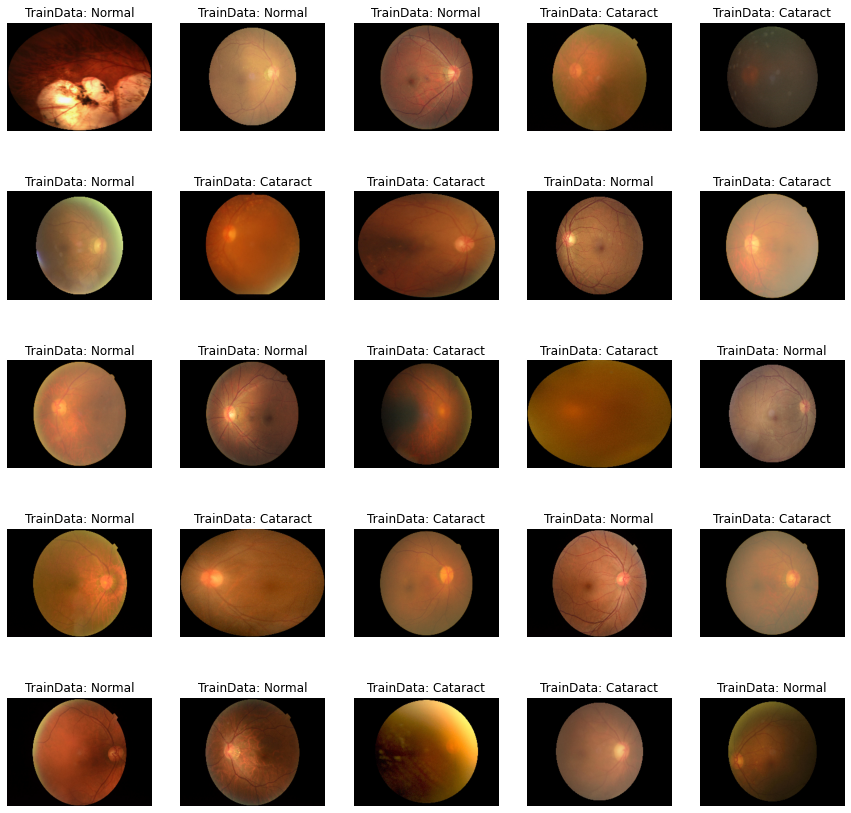

In [185]:
# plot the first 25 sheets of image data for training

f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[0][:25])
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal')
    else:
        ax[i//5, i%5].set_title('TrainData: Cataract')
plt.show()

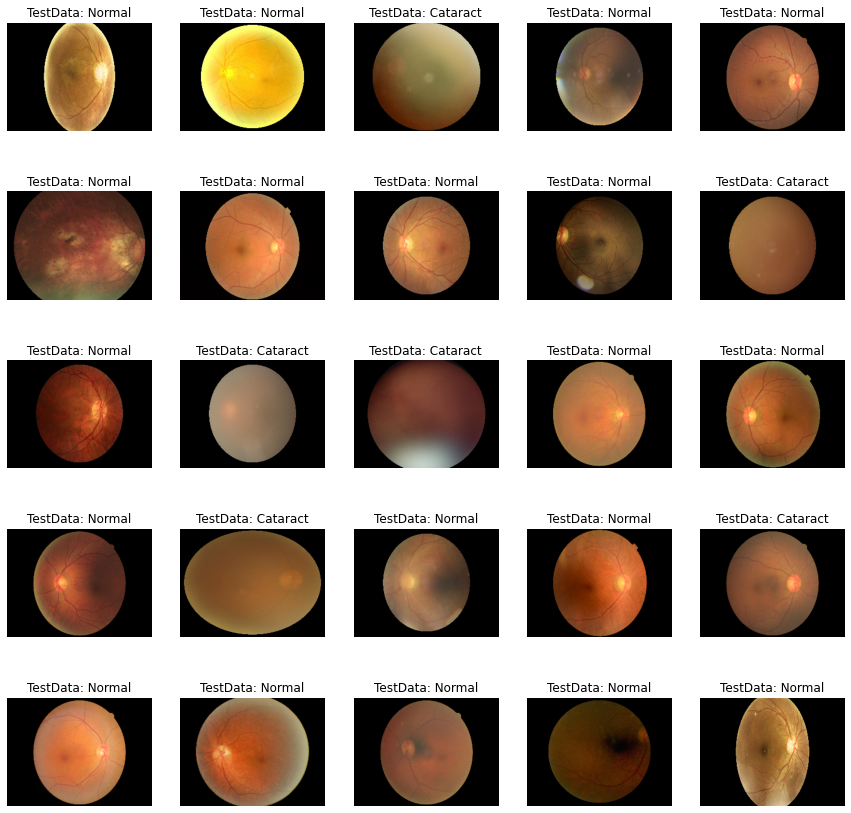

In [186]:
# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][:25])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: Cataract')
plt.show()

In [187]:
class Mish(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
def mish(x):
    return tf.keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)
 
get_custom_objects().update({'mish': Activation(mish)})

In [188]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
model = Sequential()
model.add(Conv2D(16, kernel_size=3, padding='same', 
                 input_shape=input_shape, activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [189]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 192, 256, 16)      448       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 192, 256, 16)      2320      
_________________________________________________________________
batch_normalization_8 (Batch (None, 192, 256, 16)      64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 85, 16)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 64, 85, 16)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 85, 16)        2320      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 85, 16)       

In [190]:
generator = ImageDataGenerator(horizontal_flip=True, height_shift_range=0.1, fill_mode='reflect')

es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10 ,verbose=1)

In [227]:
history = model.fit(
    generator.flow(train_imgs, train_df, batch_size=BATCH),
    epochs=10,
    steps_per_epoch=len(train_imgs) / BATCH,
    callbacks=[es_callback, reduce_lr],
    validation_data=(val_imgs, val_df.values),
)

Epoch 1/10
22/21 [==============================] - 51s 2s/step - loss: 0.4386 - acc: 0.8379 - val_loss: 1.1680 - val_acc: 0.6829
Epoch 2/10
22/21 [==============================] - 50s 2s/step - loss: 0.6855 - acc: 0.7747 - val_loss: 0.5296 - val_acc: 0.7642
Epoch 3/10
22/21 [==============================] - 50s 2s/step - loss: 0.5700 - acc: 0.8092 - val_loss: 0.4203 - val_acc: 0.8211
Epoch 4/10
22/21 [==============================] - 51s 2s/step - loss: 0.4884 - acc: 0.8264 - val_loss: 0.3960 - val_acc: 0.8293
Epoch 5/10
22/21 [==============================] - 53s 2s/step - loss: 0.4194 - acc: 0.8594 - val_loss: 0.5037 - val_acc: 0.7886
Epoch 6/10
22/21 [==============================] - 53s 2s/step - loss: 0.4190 - acc: 0.8321 - val_loss: 1.0257 - val_acc: 0.6911
Epoch 7/10
22/21 [==============================] - 53s 2s/step - loss: 0.5620 - acc: 0.8221 - val_loss: 0.4388 - val_acc: 0.8049
Epoch 8/10
22/21 [==============================] - 54s 2s/step - loss: 0.4557 - acc: 0.84

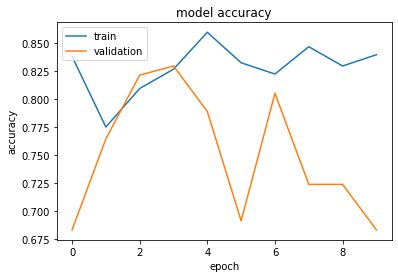

In [228]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
